In [1]:
!pip install controlnet-aux
!pip install diffusers
!pip install mediapipe
!pip install transformers
import random
import requests
import torch
from controlnet_aux import ZoeDetector
# from PIL import Image, ImageOps
from PIL import Image, ImageFilter, ImageOps, ImageDraw
import numpy as np
import cv2
import matplotlib.pyplot as plt
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
)



In [2]:


def pad_to_multiple(image, multiple):
    width, height = image.size
    new_width = (width + multiple - 1) // multiple * multiple
    new_height = (height + multiple - 1) // multiple * multiple
    padded_image = Image.new("RGBA", (new_width, new_height), (255, 255, 255, 0))
    padded_image.paste(image, (0, 0))
    return padded_image


def generate_outpainting(image_path, prompt_text, neg_prompt, output_size, random_seed=None):

    input_image = Image.open(image_path).convert("RGBA")
    original_width, original_height = input_image.size

    input_image = input_image.resize((512, 512), Image.LANCZOS)

    canvas = Image.new("RGBA", output_size, (255, 255, 255, 0))
    offset_x = (output_size[0] - 512) // 2
    offset_y = (output_size[1] - 512) // 2
    canvas.paste(input_image, (offset_x, offset_y))

    canvas = pad_to_multiple(canvas, 8)

    depth_detector = ZoeDetector.from_pretrained("lllyasviel/Annotators")
    depth_map = depth_detector(canvas, detect_resolution=512, image_resolution=max(output_size))

    depth_map = pad_to_multiple(depth_map, 8)

    control_net_models = [
        ControlNetModel.from_pretrained(
            "destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype=torch.float16, variant="fp16"
        ),
        ControlNetModel.from_pretrained("diffusers/controlnet-zoe-depth-sdxl-1.0", torch_dtype=torch.float16),
    ]

    decoder = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
    sd_pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
        "SG161222/RealVisXL_V4.0", torch_dtype=torch.float16, variant="fp16", controlnet=control_net_models, vae=decoder
    ).to("cuda")

    if random_seed is None:
        random_seed = random.randint(0, 2**32 - 1)

    seed_generator = torch.Generator(device="cpu").manual_seed(random_seed)

    generated_image = sd_pipeline(
        prompt_text,
        negative_prompt=neg_prompt,
        image=[canvas, depth_map],
        guidance_scale=6.5,
        num_inference_steps=30,
        generator=seed_generator,
        controlnet_conditioning_scale=[0.5, 0.8],
        control_guidance_end=[0.9, 0.6],
    ).images[0]

    return generated_image





/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/controlnet_aux/zoe/__init__.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

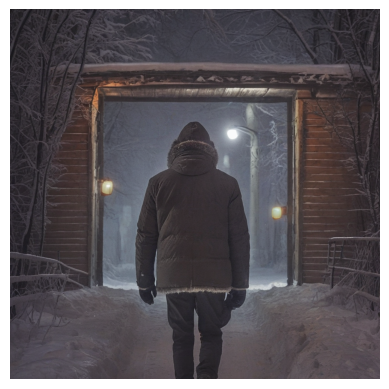

In [3]:
if __name__ == "__main__":
    image_path = "dark_winter_c.jpg"
    prompt = "high quality photo of night russian winter, dark alley, trees, flashlights"
    negative_prompt = "low quality, blurry, distorted"

    target_output_size = (1024, 1024)
    random_seed = 4138619029

    generated_img = generate_outpainting(image_path, prompt, negative_prompt, target_output_size, random_seed)
    generated_img.save("dark_winter_res.jpg")
    plt.imshow(generated_img)
    plt.axis("off")
    plt.show()